In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy.stats import truncnorm as trandn
import fast_track
import matplotlib.pyplot as plt

In [14]:
%matplotlib notebook

In [3]:
def readtfs(filename, usecols=None, index_col=0, check_lossbug=True):
    header = {}
    nskip = 1
    closeit = False

    try:
        datafile = open(filename, 'r')
        closeit = True
    except TypeError:
        datafile = filename

    for line in datafile:
        nskip += 1
        if line.startswith('@'):
            entry = line.strip().split()
            header[entry[1]] = eval(' '.join(entry[3:]))
        elif line.startswith('*'):
            colnames = line.strip().split()[1:]
            break

    if closeit:
        datafile.close()

    table = pd.read_csv(filename, delim_whitespace = True,
                        skipinitialspace = True, skiprows = nskip,
                        names = colnames, usecols = usecols,
                        index_col = index_col)

    if check_lossbug:
        try:
            table['ELEMENT'] = table['ELEMENT'].apply(lambda x: str(x).split()[0])
        except KeyError:
            pass
        try:
            for location in table['ELEMENT'].unique():
                if not location.replace(".","").replace("_","").replace('$','').isalnum():
                    print("WARNING: some loss locations in "+filename+
                          " don't reduce to alphanumeric values. For example "+location)
                    break
                if location=="nan":
                    print("WARNING: some loss locations in "+filename+" are 'nan'.")
                    break
        except KeyError:
            pass

    return header, table

In [4]:
def getPTCmap(file_name):
    _, data_ptc = readtfs(file_name)
    data_ptc['INDEX'] = np.ones(len(data_ptc.index))
    groupped = data_ptc.groupby(['N_VECTOR']).sum()

    C = np.zeros((6, int(groupped['INDEX'].iloc[0])))
    exps = np.zeros((6, int(groupped['INDEX'].iloc[0]), 6))

    for i in xrange(C.shape[0] - 1):
        new_data = data_ptc[data_ptc['N_VECTOR'] == i + 1]
        vec_tmp = new_data['COEF']
        C[i, 0:len(vec_tmp)] = vec_tmp

        exp_tmp = [np.array(map(int, list(str(new_data.index[j][3:])))) for j in xrange(len(vec_tmp))]
        exps[i, 0:len(vec_tmp), :] = exp_tmp
    return C, exps

In [5]:
def trackPTC(particles_input, turns, zs_up, zs_w,
                                co_all, C_maps, exps_maps, turnByTurn=False):

    co_zs = co_all.loc['SECTOR_1']['X']
 
    particles_int = np.copy(particles_input)
    n_part = particles_int.shape[1]


    losses = []
    extracted = []

    tmp_dpp = particles_int[5, :].copy()
    particles_int[5, :] = particles_int[4, :].copy()
    particles_int[4, :] = tmp_dpp
    
    if turnByTurn:
        particles_tot = np.zeros((particles_int.shape[0], particles_int.shape[1], turns))

    for turn in xrange(turns):
        if turnByTurn:
            particles_tot[:, :particles_int.shape[1], turn] = particles_int
        particles_int = fast_track.trackNonLinearSinglePTC(C_maps[0], exps_maps[0], particles_int)
#         particles_int, lost, extr = fast_track.quickZScheck(zs_up - co_zs, zs_w, particles_int)
#         losses.append(lost)
#         extracted.append(extr)

        particles_int = fast_track.trackNonLinearSinglePTC(C_maps[1], exps_maps[1], particles_int)
        
        particles_int = fast_track.trackNonLinearSinglePTC(C_maps[2], exps_maps[2], particles_int)

        particles_int = fast_track.trackNonLinearSinglePTC(C_maps[3], exps_maps[3], particles_int)
    
    losses_percent = sum(losses) / float(n_part)
    
    if turnByTurn:
        tmp_dpp = particles_tot[5, :, :].copy()
        particles_tot[5, :, :] = particles_tot[4, :, :].copy()
        particles_tot[4, :, :] = tmp_dpp
        return losses_percent, particles_tot

    else:
        tmp_dpp = particles_int[5, :].copy()
        particles_int[5, :] = particles_int[4, :].copy()
        particles_int[4, :] = tmp_dpp
        return losses_percent, particles_int

def normalise(u, pu, beta, alfa):
    u_norm = u / np.sqrt(beta)
    pu_norm = (u * alfa + beta * pu) / np.sqrt(beta)

    return u_norm, pu_norm

In [6]:
C = []
exps = []

for i in xrange(4):
    C_1, exps_1 = getPTCmap('/afs/cern.ch/work/f/fvelotti/private/crys_resonant_extraction/ptc_map_sector_'
                            + str(i + 1) + '_sector_' + str(i + 2) + '.tfs')
    C.append(C_1)
    exps.append(exps_1)

In [7]:
info, co_all= readtfs('/afs/cern.ch/work/f/fvelotti/private/'
                                'crys_resonant_extraction/twiss_before_map_bump.tfs')

In [33]:
particles_testPTC = np.zeros((6, 150))

In [34]:
count = 0
m = 2e-4 / 9
n = 1e-4 - (m * 10)
for i in xrange(15):
    for j in xrange(10):
        particles_testPTC[0, count] = (i + 1) * 3e-4
    
        particles_testPTC[5, count] = (j + 1) * m + n 
        
        count +=1

In [35]:
losses_tempPTC, particles_afterPTC = trackPTC(particles_testPTC, 10000, 68e-3, 500e-6, co_all, C, exps, turnByTurn=True)

In [36]:
for j in xrange(particles_afterPTC.shape[1]):
    for i in xrange(particles_afterPTC.shape[2]):
        if particles_afterPTC[0, j, i] > 0.0267:
            particles_afterPTC[:, j, i + 1:particles_afterPTC.shape[2]] = np.zeros((6, particles_afterPTC.shape[2] - i - 1))

In [37]:
xnP, pxnP = normalise((particles_afterPTC[0, :, :]), (particles_afterPTC[1, :, :]), beta=co_all.loc['SECTOR_1']['BETX'], alfa=co_all.loc['SECTOR_1']['ALFX'])

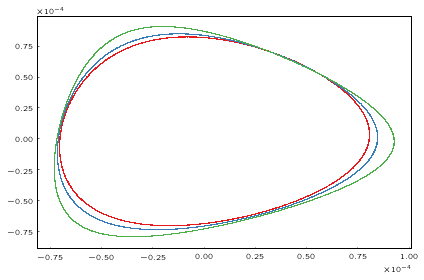

In [42]:
plt.figure()
for i in xrange(0, 3):
    plt.plot(xnP[i, :], pxnP[i, :], ',')